In [2]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sympy import cos, sin, exp, Matrix, sqrt
from sympy.simplify.fu import TR10, TR9
from sympy import evaluate
import pandas as pd

from IPython.display import display, Math
from IPython.display import display as disp
from utils import symdisp, symplot
import ipywidgets as widgets
from ipywidgets import interact

from optic.comm.modulation import modulateGray, demodulateGray, grayMapping
from optic.dsp.core import firFilter, pulseShape, lowPassFIR, pnorm, upsample
from optic.comm.metrics import signalPower
from optic.plot import eyediagram
from optic.utils import parameters

In [3]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
figsize(10, 3)
mpl.rcParams['agg.path.chunksize'] = 10000

# Optical Communications

# Generation of optical signals

In an optical digital communication system, the function of the transmitter is to convert a given sequence of bits into a train of electrical pulses which, in turn, will be used to modulate an optical carrier (laser). Modulation of optical carriers is carried out using electro-optical conversion devices.

<img src="./figuras/Tx_OOK.png" width="500">

Several modulation techniques can be implemented and several factors can influence the design of an optical transmitter.

## Lasers

A laser (*Light Amplification by Stimulated Emission of Radiation*) is a device capable of emitting light in a coherent manner. 

An ideal laser device produces collimated electromagnetic radiation (travels in parallel with a single direction) with a well-defined frequency and phase, that is, the light generated by a laser is highly directional, monochromatic (of a single *color* or wavelength) and can reach high intensities.


### Physical structure of a laser

A laser is generally made up of three main parts:

**Active medium (laser material):** This is the material responsible for light amplification. It can be solid, liquid, gaseous or semiconductor.

**Energy source (excitation source or pumping source):** It can be a beam of light or an electric current that supplies energy to the active medium, excites the atoms or molecules and raises them to a higher energy state.

**Optical resonator (laser cavity):** It consists of two mirrors positioned opposite each other to form a cavity. One of the mirrors is partially reflective (allows part of the light to escape as a laser beam) and the other is fully reflective. This system allows photons to be reflected repeatedly, amplifying the light.

<img src="./figuras/laserDiagram.png" width="600">

### Coherence in real lasers

Although a laser is one of the most coherent light sources available, it cannot be perfectly coherent due to fundamental limitations imposed by physics. These limitations are related to intrinsic factors such as the quantum behavior of light, thermal effects and laser design.

**Thermal effects**: Variations in the temperature of the active medium or the laser cavity can slightly change the optical properties of the system, such as the refractive index or cavity geometry. This leads to fluctuations in the frequency of the emitted beam (frequency shift) and consequently reduces spatial and temporal coherence.

**External instabilities**: External fluctuations, such as mechanical vibrations, electrical noise or variations in the pumping source, can introduce additional variations in the phase or amplitude of the beam, degrading coherence.

**Spontaneous amplification and spontaneous emission**: Even in well-designed lasers, some of the amplified light results from spontaneous emission. These spontaneously emitted photons do not have the same phase as photons originating from stimulated emission, which degrades the coherence of the beam.


## Representations for the optical carrier

The electric field $\mathbf{E}(t)$ of the continuous wave optical carrier can be represented by

$$\begin{equation} \mathbf{E}(t) = A \cos \left(\omega_c t + \theta\right) \mathbf{e} \end{equation}$$ 

where $\omega_c = 2\pi f_{c}\label{eq1} $ rad/s is the angular frequency of oscillation, $A$ the amplitude and $\theta$ the phase of the wave.

In [5]:
θ, omega_c, A, t = sp.symbols('θ, omega_c, A, t', real=True)

j = sp.I
π = sp.pi

E = A*cos(omega_c*t + θ)

symdisp('E(t) = ', E)

<IPython.core.display.Math object>

$E(t)=\operatorname{Re}\left[A e^{j \theta} \exp \left(j \omega_c t\right)\right]$

In [6]:
E = sp.re(A*exp(j*θ)*exp(j*omega_c*t)).simplify()

symdisp('E(t) = ', E)

<IPython.core.display.Math object>

In [7]:
E = sp.expand_trig(E).cancel()

symdisp('E(t) = ', E)

<IPython.core.display.Math object>

In [8]:
print('Carrier:')
symdisp('E(t) = ', E)

print('Polar phasor representation:')
symdisp('\hat{E}(t) = ', A*exp(j*θ))

print('Cartesian phasor representation:')
A_I = sp.re(A*exp(j*θ))
A_Q = sp.im(A*exp(j*θ))

symdisp('\hat{E}(t) = ', A_I + j*A_Q)

symdisp('A_I = ', A_I)
symdisp('A_Q = ', A_Q)

Carrier:


<IPython.core.display.Math object>

Polar phasor representation:


<IPython.core.display.Math object>

Cartesian phasor representation:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Digital modulations

A digital modulation is a $F$ function that maps bits or sets of bits to symbols (phasors) in the complex plane

$$ F: \{0, 1\}^k\rightarrow \{A_m,\theta_m\}_{m=1}^M$$

in which sequences of $k$ bits are mapped into a set of $M$ symbols ($M=2^k$).

Ex.1: $\{0, 1\}\rightarrow \{(0, 0), (A, 0)\}$ (OOK modulation) 


Ex.2: $\{0, 1\}\rightarrow \{(A, 0), (A, \pi )\}$ (BPSK modulation)


Ex.3: $\{(0, 0),(0, 1),(1, 0),(1, 1)\}\rightarrow \{(0, 0), (A/3, 0), (2A/3, 0), (A, 0)\}$ (4-PAM or 4-ASK modulation)


Ex.4: $\{(0, 0),(0, 1),(1, 0),(1, 1)\}\rightarrow \{(A, \pi/4), (A, 3\pi/4), (A, 5\pi/4), (A, 7\pi/4)\}$ (QPSK modulation)

### Constellation Diagrams

In [ ]:
# M: order of the modulation format
# constType: 'qam', 'psk', 'pam' or 'ook'

def genConst(M, constType, plotBits):
    try:
        fig = plt.figure(figsize=(4,4))
        plt.plot([],[])
        plt.grid()
        plt.ylabel('$A_Q$', fontsize=14)
        plt.xlabel('$A_I$', fontsize=14)
        plt.axis('square')
        plt.xlim(-4, 4)
        plt.ylim(-4, 4)
                
        # plot modulation bit-to-symbol mapping
        constSymb = grayMapping(M, constType)             # Gray constellation mapping
        bitMap = demodulateGray(constSymb, M, constType)  # bit mapping
        bitMap = bitMap.reshape(-1, int(np.log2(M)))

        # generate random bits
        bits = bitMap.reshape(1, -1)

        # Map bits to constellation symbols
        symbTx = modulateGray(bits, M, constType)

        # normalize symbols energy to 1
        if constType == 'ook':
            plt.xlim(-1.25*max(symbTx.real),1.25*max(symbTx.real))
            plt.ylim(-1.25*max(symbTx.real),1.25*max(symbTx.real));
            plt.vlines(0, -1.25*max(symbTx.real),1.25*max(symbTx.real))
            plt.hlines(0, -1.25*max(symbTx.real),1.25*max(symbTx.real))
        else:
            plt.xlim(1.25*min(symbTx.real),1.25*max(symbTx.real))
            plt.ylim(1.25*min(symbTx.real),1.25*max(symbTx.real));
            plt.vlines(0, 1.25*min(symbTx.real), 1.25*max(symbTx.real))
            plt.hlines(0, 1.25*min(symbTx.real), 1.25*max(symbTx.real))
        
        if M>64:
            plt.plot(symbTx.real, symbTx.imag,'o', markersize=4);
        else:
            plt.plot(symbTx.real, symbTx.imag,'o', markersize=10);                
      
        plt.title('Constellation '+str(M)+'-'+constType.upper());
        print('done')
        
        if plotBits:
            if M>=64:
                fontSize = 6
            else:
                fontSize = 12

            for ind, symb in enumerate(constSymb):
                bitMap[ind,:]
                plt.annotate(str(bitMap[ind,:])[1:-1:2], xy = (symb.real-0.05, symb.imag+0.15), size=fontSize)
                      
        
    except:
        return    
    
interact(genConst, M=[2, 4, 8, 16, 64, 256, 1024], constType=['ook','pam','psk','qam'], plotBits=[True, False]);

interactive(children=(Dropdown(description='M', options=(2, 4, 8, 16, 64, 256, 1024), value=2), Dropdown(descr…

## Mach-Zehnder Modulator


<img src="./figuras/MZM.png" width="600">


$$\begin{equation}
\left[\begin{array}{l}
\hat{E}_{1} \\
\hat{E}_{2}
\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{ll}
1 & j \\
j&1
\end{array}\right]\left[\begin{array}{cc}
e^{j \phi_{1}} & 0 \\
0 & e^{j \phi_{2}}
\end{array}\right]\frac{1}{\sqrt{2}}\left[\begin{array}{ll}
1 & j \\
j&1
\end{array}\right]\left[\begin{array}{c}
\hat{E}_{i} \\
0
\end{array}\right]
\end{equation}$$

In [10]:
print('Carrier:')
symdisp('E(t) = ', E)

print('Simplification: θ = 0')

E_ = E.subs({θ:0})
symdisp('E(t) = ', E)
symdisp('\hat{E}(t) = ', A)

Carrier:


<IPython.core.display.Math object>

Simplification: θ = 0


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [11]:
ϕ1, ϕ2, ϕ = sp.symbols('ϕ1, ϕ2, ϕ', real=True)
Ai        = sp.symbols('A_i', real=True)

In [12]:
C  = 1/sqrt(2)*Matrix([[1, j],[j, 1]])

symdisp('C = ', C)

<IPython.core.display.Math object>

In [13]:
M = Matrix([[exp(j*ϕ1), 0],[0, exp(j*ϕ2)]])

symdisp('M = ', M)

<IPython.core.display.Math object>

In [14]:
T = C*M*C

symdisp('T = ', T)

<IPython.core.display.Math object>

In [15]:
Ei = Matrix([[Ai],[0]])

symdisp('\hat{E}_i = ', Ei)

<IPython.core.display.Math object>

In [16]:
Eo = T*Ei
symdisp('\hat{E}_o = ', Eo)

<IPython.core.display.Math object>

In [17]:
Eo[0].subs({ϕ1:ϕ, ϕ2:-ϕ}).simplify()

I*A_i*sin(ϕ)

$$\begin{equation}
\frac{\hat{E}_{\text {out }}(t)}{\hat{E}_{\text {in }}(t)}=\frac{1}{2} \left(e^{j \varphi(t)}+e^{-j \varphi(t)}\right)e^{j\frac{\pi}{2}}
\end{equation}$$

$$
\varphi(t)=\frac{1}{2V_{\pi}}[u(t)+V_b]\pi
$$

$$\begin{equation}
A_{\text {out}}(t) = A_{i n}(t) \cos \left(\frac{1}{2V_{\pi}}[u(t)+V_b]\pi\right)
\end{equation}$$

In [18]:
from optic.models.devices import mzm

help(mzm)

Help on function mzm in module optic.models.devices:

mzm(Ai, u, param=None)
    Optical Mach-Zehnder Modulator (MZM).
    
    Parameters
    ----------
    Ai : scalar or np.array
        Amplitude of the optical field at the input of the MZM.
    u : np.array
        Electrical driving signal.
    param : optic.utils.parameters object, optional
        Parameters of the MZM model.
    
        - param.Vpi: MZM's Vpi voltage [V][default: 2 V]
        - param.Vb: MZM's bias voltage [V][default: -1 V]
    
    Returns
    -------
    Ao : np.array
        Modulated optical field at the output of the MZM.
    
    References
    ----------
    [1] G. P. Agrawal, Fiber-Optic Communication Systems. Wiley, 2021.
    
    [2] M. Seimetz, High-Order Modulation for Optical Fiber Transmission. em Springer Series in Optical Sciences. Springer Berlin Heidelberg, 2009.



c:\Users\edson.DESKTOP-54IJM4F\anaconda3\envs\opticommpy-env\Lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


### Transmitting information at the intensity (power) of the optical carrier ($V_b = \pm V_π/2$)

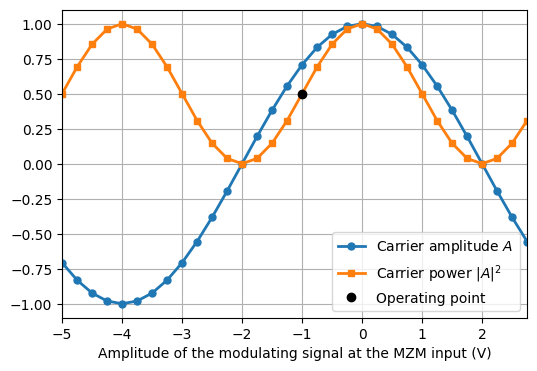

In [19]:
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi/2

u = np.arange(-2*paramMZM.Vpi, 2*paramMZM.Vpi, 0.25) # generates values ​​between -2Vπ and 2Vπ

Ai = 1
Ao = mzm(Ai, u, paramMZM)


plt.figure(figsize=(6,4))
plt.plot(u+paramMZM.Vb, Ao,'-o', markersize = 5, label = 'Carrier amplitude $A$ ', linewidth = 2);
plt.xlabel('Amplitude of the modulating signal at the MZM input (V)')
plt.xlim(min(u+paramMZM.Vb), max(u+paramMZM.Vb));

plt.plot(u+paramMZM.Vb, np.abs(Ao)**2, '-s', markersize = 5, label = 'Carrier power $|A|^2$', linewidth = 2);
plt.xlabel('Amplitude of the modulating signal at the MZM input (V)')
plt.xlim(min(u+paramMZM.Vb), max(u+paramMZM.Vb));

# plots operating point
Aop = mzm(Ai, 0, paramMZM)
plt.plot(paramMZM.Vb, np.abs(Aop)**2,'ko', markersize = 6, label = 'Operating point', linewidth = 2);
plt.legend()
plt.grid()

### Transmitting information in the amplitude of the electric field ($V_b = \pm V_π$)

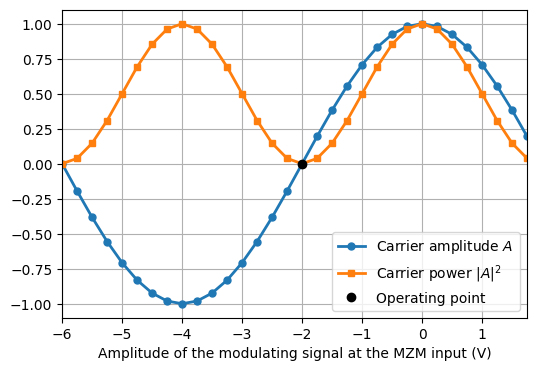

In [20]:
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi

u  = np.arange(-2*paramMZM.Vpi, 2*paramMZM.Vpi, 0.25) # generates values ​​between -2Vπ and 2Vπ

Ai = 1
Ao = mzm(Ai, u, paramMZM)

plt.figure(figsize=(6,4))
plt.plot(u+paramMZM.Vb, Ao,'-o', markersize = 5, label = 'Carrier amplitude $A$ ', linewidth = 2);
plt.xlabel('Amplitude of the modulating signal at the MZM input (V)')
plt.xlim(min(u+paramMZM.Vb), max(u+paramMZM.Vb));

plt.plot(u+paramMZM.Vb, np.abs(Ao)**2, '-s', markersize = 5, label = 'Carrier power $|A|^2$', linewidth = 2);
plt.xlabel('Amplitude of the modulating signal at the MZM input (V)')
plt.xlim(min(u+paramMZM.Vb), max(u+paramMZM.Vb));

# plots operating point
Aop = mzm(Ai, 0, paramMZM)
plt.plot(paramMZM.Vb, Aop,'ko', markersize = 6, label = 'Operating point', linewidth = 2);
plt.legend()
plt.grid()

### Extinction ratio

$$ER_{dB} = 10\log_{10}\frac{P_1}{P_0} $$

Extinction ratio (ER)
ER = 30.45 dB


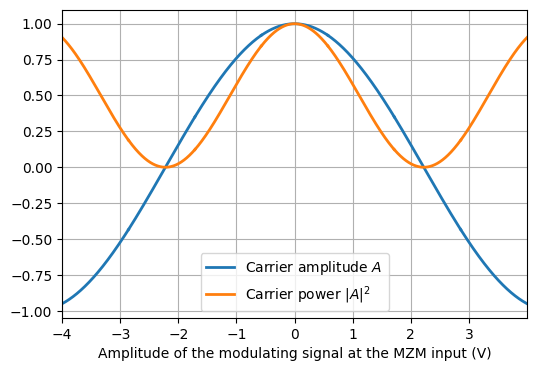

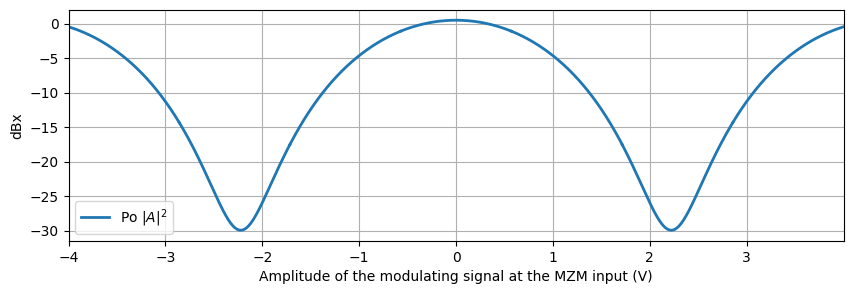

In [21]:
# MZM parameters
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = 0
u  = np.arange(-2*paramMZM.Vpi, 2*paramMZM.Vpi, 0.00013) # generates values ​​between -2Vπ and 2Vπ

Ai = 1
Ao = mzm(Ai, 0.9*u, paramMZM) # generates the response curve, the MZM

plt.figure(figsize=(6,4))
plt.plot(u, Ao,'-', markersize = 5, label = 'Carrier amplitude $A$ ', linewidth = 2);
plt.xlabel('Amplitude of the modulating signal at the MZM input (V)')
plt.xlim(min(u), max(u));

plt.plot(u, np.abs(Ao)**2, '-', markersize = 5, label = 'Carrier power $|A|^2$', linewidth = 2);
plt.xlabel('Amplitude of the modulating signal at the MZM input (V)')
plt.xlim(min(u), max(u));
plt.legend()
plt.grid()

P  = 10*np.log((np.abs(Ao)**2 + 0.05))

plt.figure()
plt.plot(u, P, label = 'Po $|A|^2$', linewidth = 2);
plt.xlabel('Amplitude of the modulating signal at the MZM input (V)')
plt.ylabel('dBx')
plt.xlim(min(u), max(u));
plt.legend()
plt.grid()

print('Extinction ratio (ER)')

print('ER = %.2f dB'%(max(P)-min(P)))

## Signaling intervals

Digital transmitters make use of the communication channel to transmit information according to a time base, generally called **signaling interval** ($T_s$). The signaling interval is the time interval in which the transmitter sends a discrete symbol mapped into a continuous pulse. The inverse of the signaling interval is called the symbol transmission rate ($R_s$), i.e. $R_s=1/T_s$.

The number of bits sent in each signaling interval multiplied by $R_s$ corresponds to the system bit transmission rate ($R_b$). Assuming that each symbol of a digital modulation represents a sequence of $k$ bits, we have:

$$R_b = kR_s $$

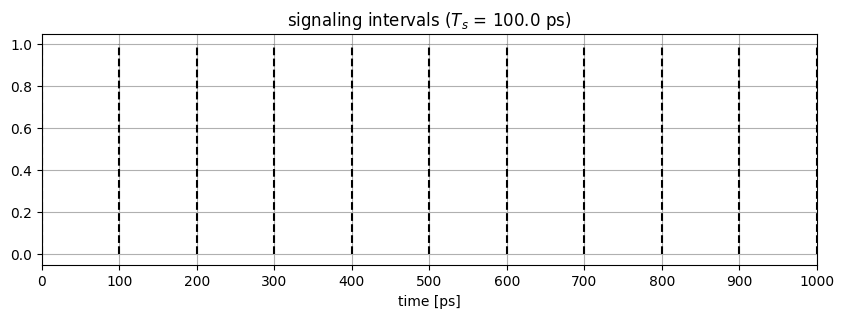

In [23]:
Rs  = 10e9  # Symbol rate [baud]
Ts  = 1/Rs  # Symbol period in seconds
N   = 10    # number of signaling intervals

t = np.arange(0, N+1)*(Ts/1e-12) # time in picoseconds (ps)

plt.vlines(t, 0, 1, linestyles='dashed', color = 'k')    
plt.xlabel('time [ps]');
plt.title('signaling intervals ($T_s$ = %.1f ps)'%(Ts/1e-12));
plt.grid()
plt.xticks(t);
plt.xlim(0, t.max());

### Sampling theorem

The *Nyquist-Shannon* sampling theorem is one of the most important results used in digital signal processing, serving as a fundamental bridge between continuous-time signals and discrete-time signals. The theorem establishes a **sufficient condition** for a sampling rate that allows a discrete sequence of samples to capture all the information from a signal that is continuous in time and has a finite bandwidth.

Consider $x(t)$ a band-limited signal, i.e. the frequency spectrum of $X(f)=\mathcal{F}\{x(t)\}$ is contained in the interval $-B\leq f \leq B$, that is 

$$ X(f) = \int_{-\infty}^{\infty} x(t)e^{j2\pi f t} dt = 0 \text{, se } f < -B \text{ ou } f > B$$

Suppose we obtain a discrete signal in time $x[k]$ from a set of equispaced samples of $x(t)$, that is, $x[k]=x(kT_a)$, where $T_a = \frac{1}{f_a}$ is the sampling period and $f_a$ the sampling frequency.

If $f_a\geq 2B$, $x(t)$ can be perfectly reconstructed from its samples $x[k]$ by doing

$$
x(t)=\sum_{n=-\infty}^{\infty} x(k T_a) \operatorname{sinc}\left(\frac{t-kT_a}{T_a}\right).
$$


In [26]:
from optic.dsp.core import firFilter, pulseShape
from optic.plot import eyediagram

def sincInterp(x, fa):
    
    fa_sinc = 32*fa
    Ta_sinc = 1/fa_sinc
    Ta = 1/fa
    t = np.arange(0, x.size*32)*Ta_sinc
    
    plt.figure()  
    y = upsample(x,32)
    y[y==0] = np.nan
    plt.plot(t,y.real,'ko', label='x[k]')
    
    x_sum = 0
    for k in range(0, x.size):
        xk_interp = x[k]*np.sinc((t-k*Ta)/Ta)
        x_sum += xk_interp
        plt.plot(t, xk_interp)           
    
    plt.legend(loc="upper right")
    plt.xlim(min(t), max(t))
    plt.grid()
    
    return x_sum, t

### Example 1: sinc(t) function

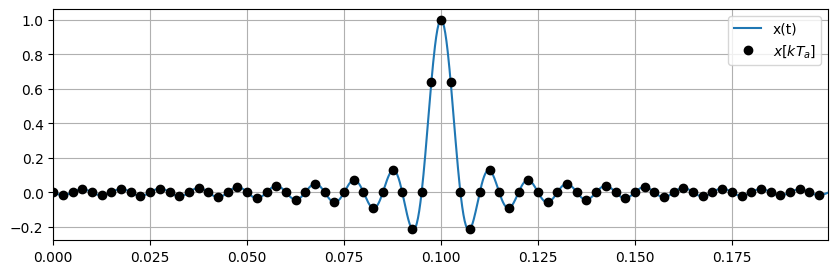

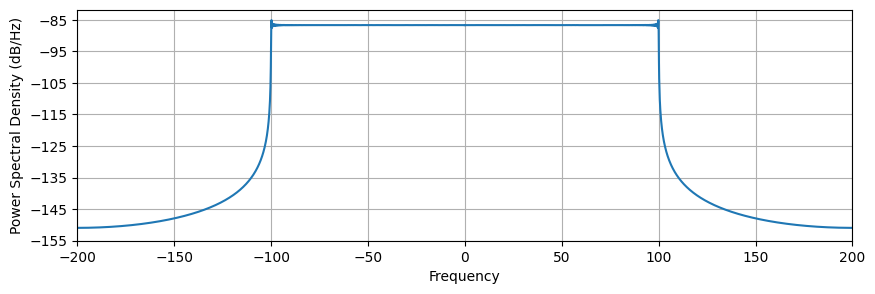

In [27]:
Fa = 400   # sampling frequency
B  = 100   # sync band
Ta = 1/Fa  # sampling period

t = np.arange(0, 0.2, Ta/16) # signal duration [s]
d = t.size/2
x = np.sinc(2*B*(t-d*(Ta/16)))

# signal sampled with sampling frequency fa
xa = x[::16]
ta = t[::16]

plt.figure()
plt.plot(t, x,'-', label = 'x(t)')
plt.plot(ta, xa,'ko', label = '$x[kT_a]$')
plt.grid()
plt.legend()
plt.xlim(min(t), max(t))

# psd plot
x_psd = np.sinc(2*B*((np.arange(0, 2000)*Ta)-1000*Ta))
plt.figure();
plt.psd(x_psd, Fs=Fa, NFFT = 16*1024, sides='twosided')
plt.xlim(-Fa/2, Fa/2);

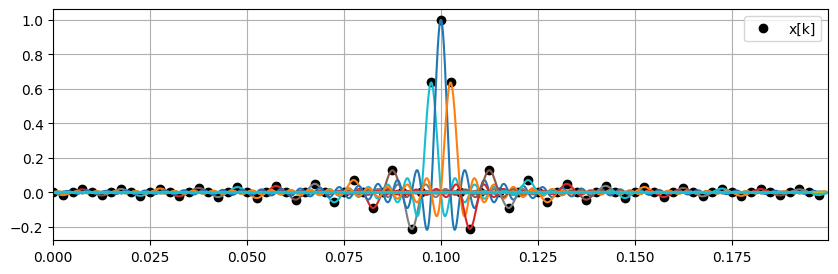

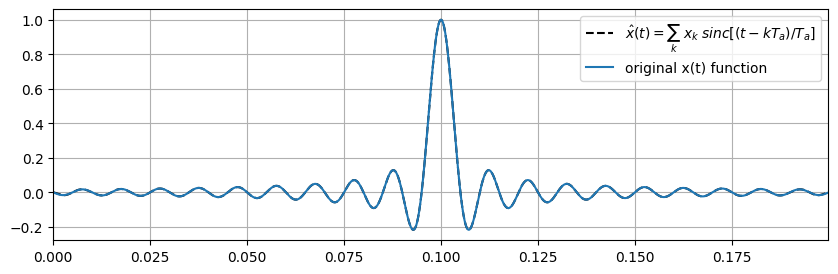

In [28]:
x_interp, t_interp = sincInterp(xa, Fa);

plt.figure()
plt.plot(t_interp, x_interp,'--k',label ='$\hat{x}(t) =\sum_{k}\;x_{k}\;sinc[(t-kT_a)/T_a]$');
plt.plot(t, x,'-',label = 'original x(t) function')
plt.xlim(min(t), max(t))
plt.grid()
plt.legend();

### Example 2: linear frequency chirp

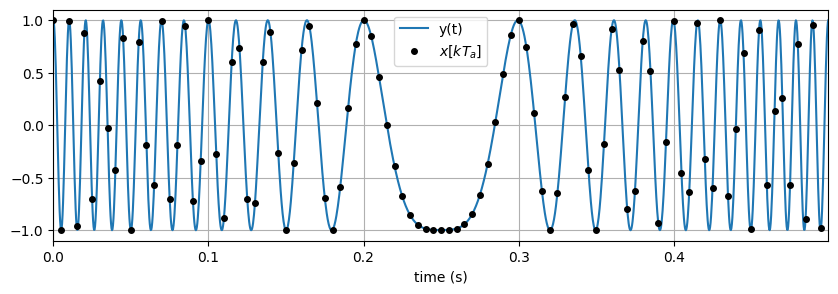

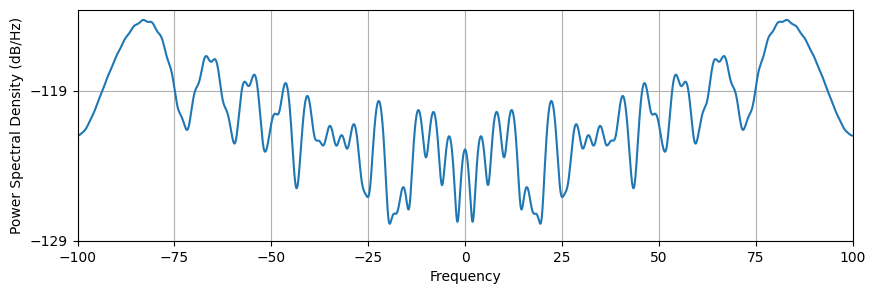

In [31]:
from scipy.signal import chirp

Fa = 200   # sampling frequency
Ta = 1/Fa  # sampling period
B  = 100

d = 1600
t = np.arange(0, 0.5, Ta/16) # signal duration [s]

x = chirp(t, f0=-100, f1=100, t1=max(t), method='linear')

# signal sampled with sampling frequency fa
xa = x[::16]
ta = t[::16]

plt.figure()
plt.plot(t, x,'-', label = 'y(t)')
plt.plot(ta, xa,'ko', markersize = 4, label = '$x[kT_a]$')
plt.xlabel('time (s)')
plt.grid()
plt.legend()
plt.xlim(min(t), max(t))

# psd plot
plt.figure();
plt.psd(xa, Fs=Fa, NFFT = 16*1024, sides='twosided')
plt.xlim(-Fa/2, Fa/2);

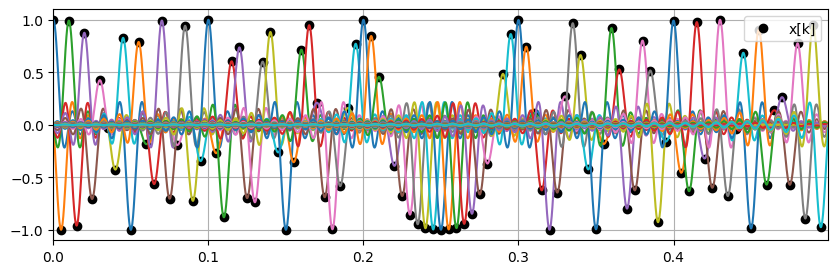

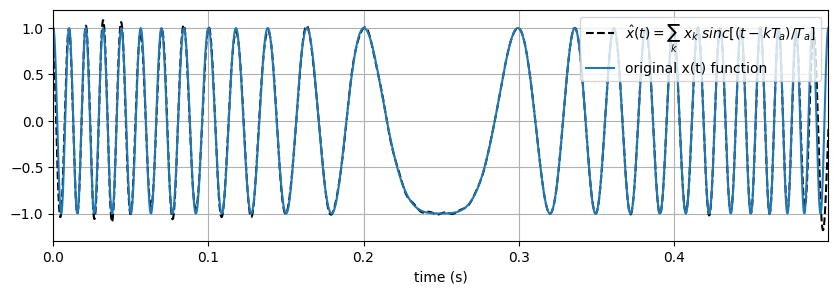

In [32]:
x_interp, t_interp = sincInterp(xa, Fa);

plt.figure()
plt.plot(t_interp, x_interp,'--k',label ='$\hat{x}(t) =\sum_{k}\;x_{k}\;sinc[(t-kT_a)/T_a]$');
plt.plot(t, x,'-',label = 'original x(t) function')
plt.xlabel('time (s)')
plt.xlim(min(t), max(t))
plt.grid()
plt.legend(loc='upper right');

## OOK amplitude modulation

$ E(t)=\operatorname{Re}\left[A(t) e^{j \theta} \exp \left(j \omega_c t\right)\right]$

$$ \begin{align} A(t) &= \left[ \sum_{n} s_{n} \delta \left(t-n T_{s}\right)\right] \ast p(t) \nonumber \\ & = \sum_{n} s_{n} p\left(t-n T_{s}\right)\end{align}$$

In [33]:
# simulation parameters
Rs     = 10e9          # Symbol rate (for the case of OOK Rs = Rb)
Ts     = 1/Rs          # Symbol period in seconds

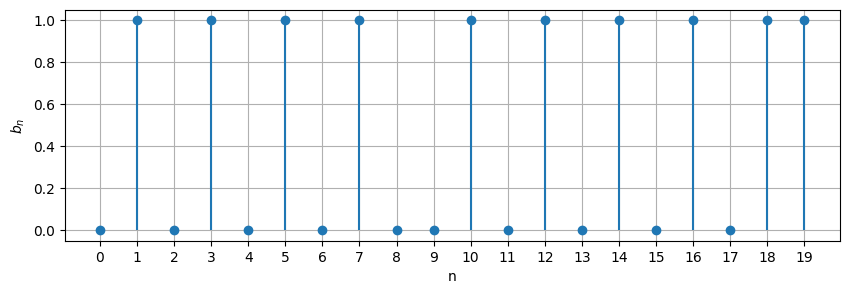

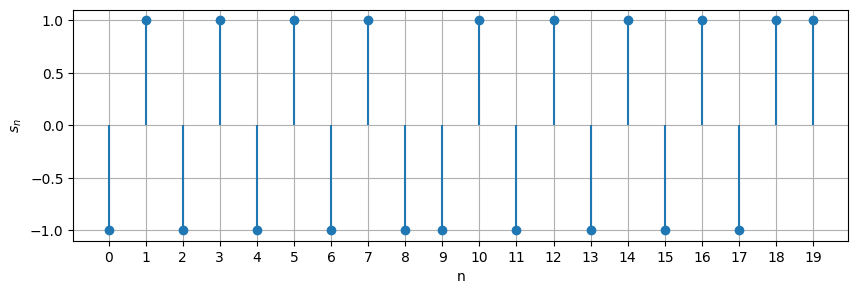

In [34]:
# generates sequence of pseudo-random bits
bits   = np.random.randint(2, size=20)    
n      = np.arange(0, bits.size)

# maps bits to binary symbols
symbTx = 2*bits-1

plt.figure(1)
plt.stem(bits, basefmt=" ")
plt.xlabel('n')
plt.ylabel('$b_n$')
plt.grid()
plt.xticks(np.arange(0, bits.size));

plt.figure(2)
plt.stem(symbTx, basefmt=" ")
plt.xlabel('n')
plt.ylabel('$s_n$')
plt.grid()
plt.xticks(np.arange(0, symbTx.size));

### Generating binary OOK signals

#### Ideal rectangular pulse

<IPython.core.display.Math object>

<IPython.core.display.Math object>

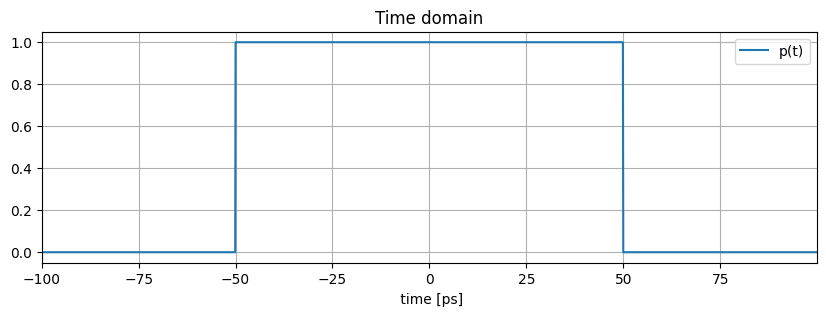

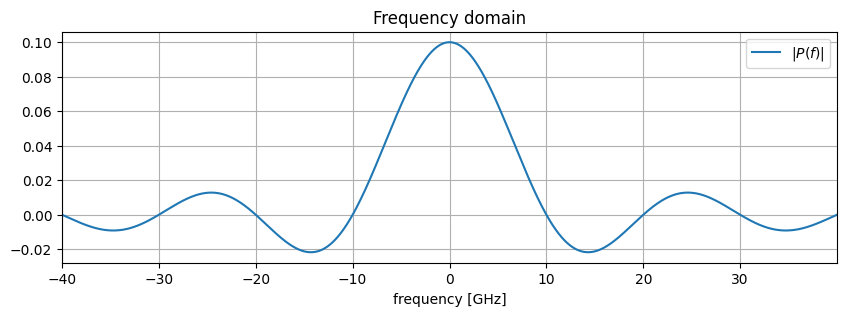

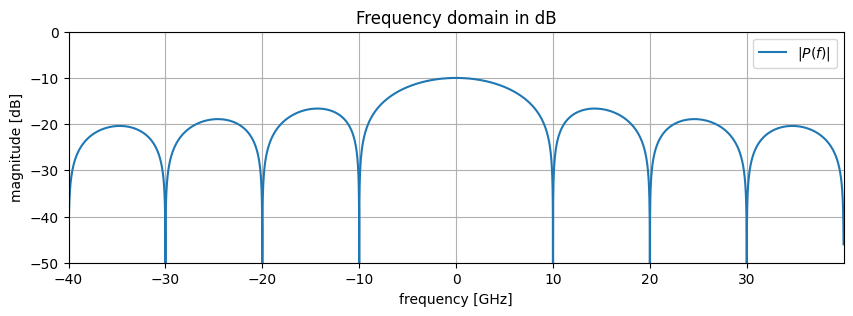

In [35]:
from sympy import fourier_transform as FT
from sympy import inverse_fourier_transform as iFT
from sympy import oo as infty

def rect(t, a):
    return (sp.Heaviside(t + a) - sp.Heaviside(t - a))

t, f = sp.symbols('t, f', real=True)
Ts = sp.symbols('T_s', real=True, positive=True)

# rectangular wrist
p = rect(t, Ts/2)
P = FT(p, t, f)

symdisp('p(t) = ', p)
symdisp('P(f) = ', P)

intervalo_f = np.arange(-4, 4, 0.001)*(Rs/1e9)
intervalo_t = np.arange(-1, 1, 0.001)*(1/(Rs/1e12))

symplot(t, p.subs({Ts:1/(Rs/1e12)}), intervalo_t, funLabel='p(t)', xlabel=' time [ps]');
plt.title('Time domain')
symplot(f, P.subs({Ts:1/(Rs/1e9)}), intervalo_f, funLabel='$|P(f)|$', xlabel= 'frequency [GHz]');
plt.title('Frequency domain')
symplot(f, 10*sp.log(sp.Abs(P.subs({Ts:1/(Rs/1e9)})), 10), intervalo_f, funLabel='$|P(f)|$', 
        xlabel= 'frequency [GHz]', ylabel= 'magnitude [dB]');
plt.title('Frequency domain in dB')
plt.ylim(-50, 0);

In [36]:
# simulation parameters
SpS = 128           # Samples by symbol
Rs  = 10e9          # Symbol rate (for the case of OOK Rs = Rb)
Ts  = 1/Rs          # Symbol period in seconds
Fa  = 1/(Ts/SpS)    # Signal sampling frequency (samples/second)
Ta  = 1/Fa          # Sampling period

# ideal rectangular wrist
pulse = pulseShape('rect', SpS)
pulse = pulse/max(abs(pulse))

t = (0.5+np.arange(0, pulse.size))*(Ta/1e-12) # time in ps

plt.figure(1)
plt.plot(t, pulse,'-', label = 'p(t)', linewidth=3)
plt.xlabel('time [ps]')
plt.ylabel('amplitude')
plt.xlim(min(t), max(t))
plt.grid()
plt.legend();

TypeError: pulseShape() takes 1 positional argument but 2 were given

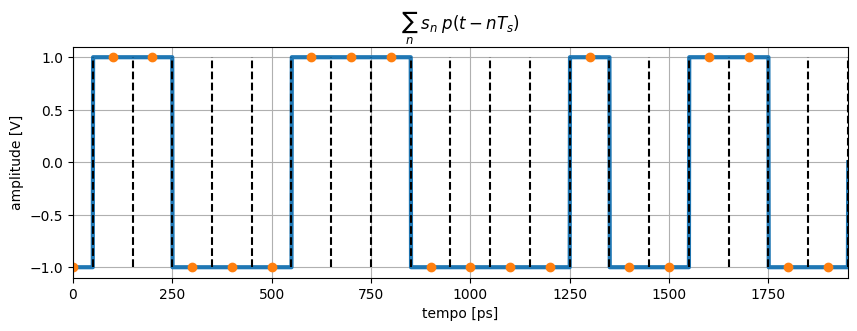

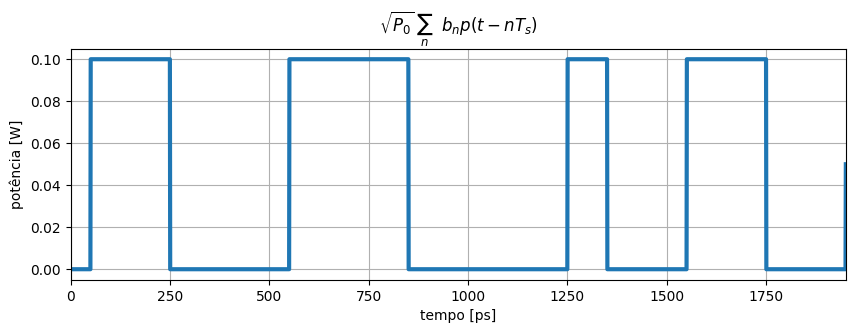

In [ ]:
# upsampling
symbolsUp = upsample(symbTx, SpS)

# rectangular pulse formatting
sigTx  = firFilter(pulse, symbolsUp)
sigTx  = sigTx.real

# signal plot
t = np.arange(0, sigTx.size)*(Ta/1e-12)

# central instants of signaling intervals
symbolsUp = upsample(2*bits-1, SpS).astype(np.float64)
symbolsUp[symbolsUp==0] = np.nan

plt.figure(2)
plt.plot(t, sigTx,'-', linewidth=3)
plt.plot(t, symbolsUp.real, 'o')
plt.xlabel('time [ps]')
plt.ylabel('amplitude [V]')
plt.title('$\sum_{n}\;s_{n}\;p(t-n T_s)$')
plt.grid()

t = (0.5 + np.arange(0, bits.size))*(Ts/1e-12)
plt.vlines(t, -1, 1, linestyles='dashed', color = 'k');
plt.xlim(0, max(t));

# optical modulation
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi/2

P0 = 100e-3 # CW carrier power at the input to the MZM
Ai = np.sqrt(P0)
sigTxo = mzm(Ai, (paramMZM.Vpi/2)*sigTx, paramMZM)

# signal plot
t = np.arange(0, sigTxo.size)*(Ta/1e-12)

plt.figure(3)
plt.plot(t, np.abs(sigTxo)**2,'-', linewidth=3)
plt.xlabel('time [ps]')
plt.ylabel('potência [W]')
plt.title('$\sqrt{P_0}\;\sum_{n}\;\;b_{n}p(t-n T_s)$')
plt.grid()

t = (0.5 + np.arange(0, bits.size))*(Ts/1e-12)
plt.xlim(0, max(t));

#### Typical NRZ pulse

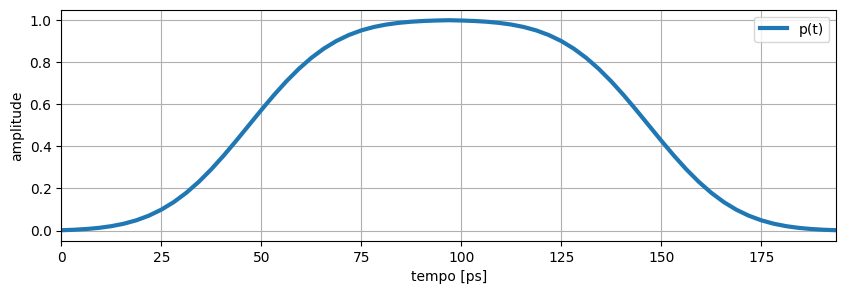

In [ ]:
# simulation parameters
SpS = 32           # Samples by symbol
Fa  = 1/(Ts/SpS)    # Signal sampling frequency (samples/second)
Ta  = 1/Fa          # Sampling period

# typical NRZ pulse
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

t = np.arange(0, pulse.size)*(Ta/1e-12)

plt.figure(1)
plt.plot(t, pulse,'-', label = 'p(t)', linewidth=3)
plt.xlabel('time [ps]')
plt.ylabel('amplitude')
plt.xlim(min(t), max(t))
plt.grid()
plt.legend();

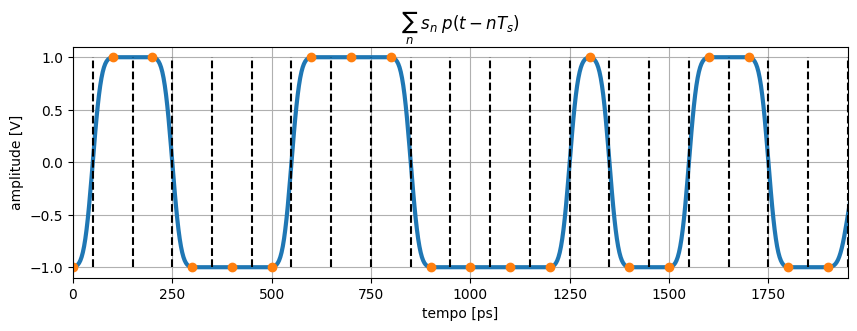

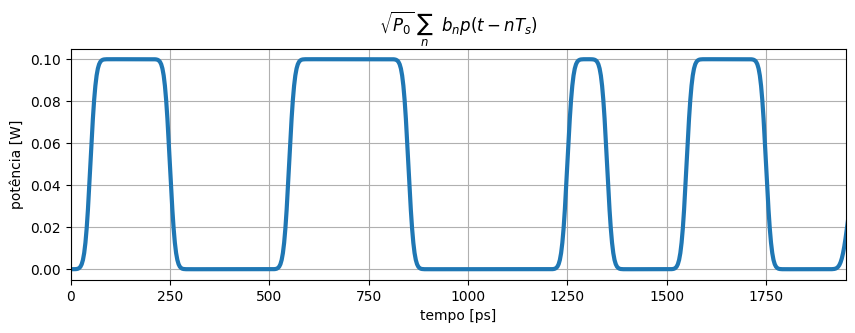

In [ ]:
# upsampling
symbolsUp = upsample(symbTx, SpS).astype(np.float64)

# NRZ pulse shaping
sigTx  = firFilter(pulse, symbolsUp)
sigTx = sigTx.real

t = np.arange(0, sigTx.size)*(Ta/1e-12)

# central instants of signaling intervals
symbolsUp[symbolsUp==0] = np.nan

plt.figure(2)
plt.plot(t, sigTx,'-',linewidth=3)
plt.plot(t, symbolsUp.real,'o')
plt.xlabel('time [ps]')
plt.ylabel('amplitude [V]')
plt.title('$\sum_{n}\;s_{n}\;p(t-n T_s)$')
plt.grid()

t = (0.5*Ts + np.arange(0, bits.size*Ts, Ts))/1e-12
plt.vlines(t, -1, 1, linestyles='dashed', color = 'k');
plt.xlim(0, max(t));

# optical modulation
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi/2

P0 = 100e-3 # CW carrier power at the input to the MZM
Ai = np.sqrt(P0)
sigTxo = mzm(Ai, (paramMZM.Vpi/2)*sigTx, paramMZM)

# signal plot
t = np.arange(0, sigTxo.size)*(Ta/1e-12)

plt.figure(3)
plt.plot(t, np.abs(sigTxo)**2,'-', linewidth=3)
plt.xlabel('time [ps]')
plt.ylabel('potência [W]')
plt.title('$\sqrt{P_0}\;\sum_{n}\;\;b_{n}p(t-n T_s)$')
plt.grid()

t = (0.5 + np.arange(0, bits.size))*(Ts/1e-12)
plt.xlim(0, max(t));

#### Cosine pulse raised

$$\large
p(t)=\left\{\begin{array}{ll}
\frac{\pi}{4 T} \operatorname{sinc}\left(\frac{1}{2 \beta}\right), & t=\pm \frac{T}{2 \beta} \\
\frac{1}{T} \operatorname{sinc}\left(\frac{t}{T}\right) \frac{\cos \left(\frac{\pi \beta t}{T}\right)}{1-\left(\frac{2 \beta t}{T}\right)^{2}}, & \text { otherwise }
\end{array}\right.
$$

$$\large
P(f)=\left\{\begin{array}{ll}
1, & |f| \leq \frac{1-\beta}{2 T} \\
\frac{1}{2}\left[1+\cos \left(\frac{\pi T}{\beta}\left[|f|-\frac{1-\beta}{2 T}\right]\right)\right], & \frac{1-\beta}{2 T}<|f| \leq \frac{1+\beta}{2 T} \\
0, & \text { otherwise }
\end{array}\right.
$$

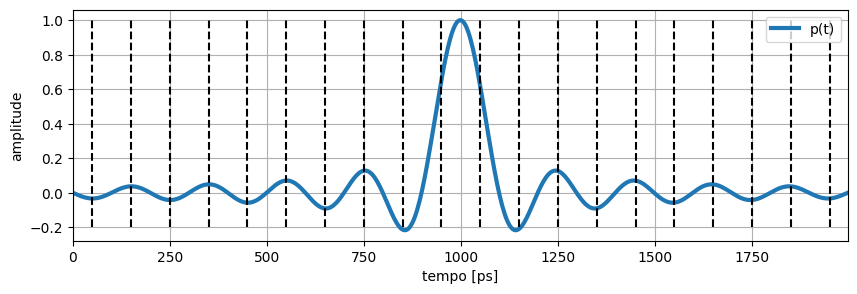

In [ ]:
# raised cosine pulse
Ncoeffs = 640
rolloff = 0.01

pulse = pulseShape('rc', SpS, Ncoeffs, rolloff, Ts)
pulse = pulse/max(abs(pulse))

t = np.arange(0, pulse.size)*(Ta/1e-12)

plt.figure(1)
plt.plot(t, pulse,'-', label = 'p(t)', linewidth=3)
plt.xlabel('time [ps]')
plt.ylabel('amplitude')
plt.xlim(min(t), max(t))
plt.grid()
plt.legend()

t = (-0.0*Ts + np.arange(0, (Ncoeffs/SpS)*Ts, Ts))/1e-12
plt.vlines(t + 0.5*(Ts/1e-12), -0.2, 1, linestyles='dashed', color = 'k');

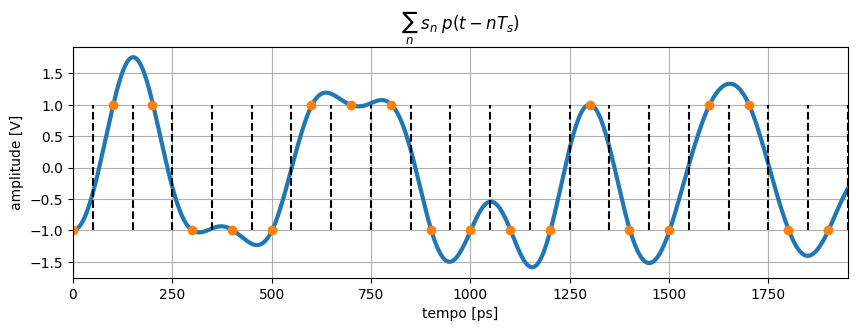

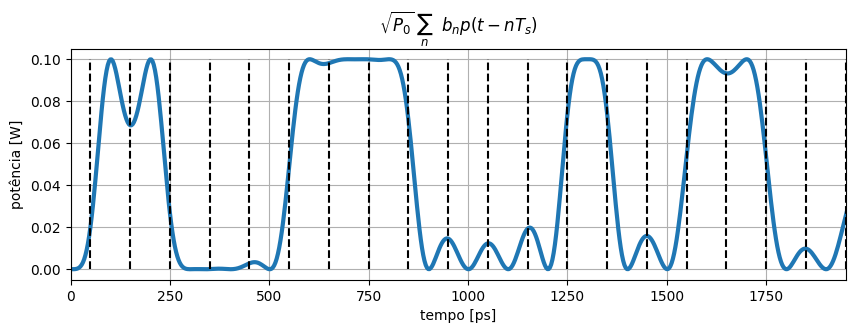

In [ ]:
# upsampling
symbolsUp = upsample(symbTx, SpS).astype(np.float64)

# pulse formatting
sigTx  = firFilter(pulse, symbolsUp)
sigTx = sigTx.real

t = np.arange(0, sigTx.size)*(Ta/1e-12)

# central instants of signaling intervals
symbolsUp[symbolsUp==0] = np.nan

plt.figure(2)
plt.plot(t, sigTx,'-', linewidth=3)
plt.plot(t, symbolsUp.real,'o')
plt.xlabel('time [ps]')
plt.ylabel('amplitude [V]')
plt.title('$\sum_{n}\;s_{n}\;p(t-n T_s)$')
plt.grid()

t = (0.5*Ts + np.arange(0, bits.size*Ts, Ts))/1e-12
plt.vlines(t, -1, 1, linestyles='dashed', color = 'k');
plt.xlim(0, max(t));

# optical modulation
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi/2

P0 = 100e-3 # CW carrier power at the input to the MZM
Ai = np.sqrt(P0)
sigTxo = mzm(Ai, (paramMZM.Vpi/2)*sigTx, paramMZM)

# signal plot
t = np.arange(0, sigTxo.size)*(Ta/1e-12)

plt.figure(3)
plt.plot(t, np.abs(sigTxo)**2,'-', linewidth=3)
plt.xlabel('time [ps]')
plt.ylabel('potência [W]')
plt.title('$\sqrt{P_0}\;\sum_{n}\;\;b_{n}p(t-n T_s)$')
plt.grid()

t = (0.5 + np.arange(0, bits.size))*(Ts/1e-12)
plt.xlim(0, max(t));
plt.vlines(t, 0, P0, linestyles='dashed', color = 'k');
plt.xlim(0, max(t));

## Power spectral density of digitally modulated signals

Consider $v(t)$ to be a baseband modulated signal in the time domain associated with a sequence of symbols $\{s_n\}$ of a given modulation format, that is

$$ \begin{equation}
v(t)=\sum_{n=-\infty}^{\infty} s_{n} p(t-n T).
\end{equation}
$$

where $p(t)$ is the pulse shape used. The signal $v(t)$ can be understood as a realization of the stochastic process $V(t)$ which, in turn, depends on the random sequence of symbols $\{s_n\}$. For each distinct realization of $\{s_n\}$ we have an associated waveform $v(t)$.


### Average value and autocorrelation of $V(t)$


#### Average value

$$
\begin{equation}
\begin{aligned}
E[V(t)] &=\sum_{n=-\infty}^{\infty} E\left[s_{n}\right] p(t-n T) \\
&=m_{s} \sum_{n=-\infty}^{\infty} p(t-n T)
\end{aligned}
\end{equation}
$$

Note that $E[V(t)]$ is periodic in $t$ with period $T$, which corresponds to the signaling interval.


#### Autocorrelation

$$
\begin{equation}
R_{V}(t+\tau, t)=E\left[V^{*}(t) V(t+\tau)\right]=\sum_{n=-\infty}^{\infty} \sum_{m=-\infty}^{\infty} E\left[s_{n}^{*} s_{m}\right] p(t-nT) p(t+\tau-mT)
\end{equation}
$$

Considering that $\{s_n\}$ is a sequence of stationary information symbols in the broad sense, its autocorrelation $R_{s}$ is defined as

$$
\begin{equation}
\begin{aligned}
R_{s}(n,n+m)&=E\left[s_{n}^{*}s_{n+m}\right]\nonumber\\
        &=R_{s}((n+m)-n)\nonumber\\
        &=R_{s}(m)
\end{aligned}
\end{equation}
$$

Then,
$$
\begin{equation}
R_{V}(t+\tau, t) =\sum_{n=-\infty}^{\infty} \sum_{m=-\infty}^{\infty} R_{s}(m-n) p(t-nT) p(t+\tau-mT).
\end{equation}
$$


We can rewrite the sums in a more convenient way by changing variables $m'= m-n$, so that

$$
\begin{equation}
\begin{aligned}
R_{V}(t+\tau, t) &=\sum_{n=-\infty}^{\infty} \sum_{m=-\infty}^{\infty} R_{s}(m-n) p(t-nT) p(t+\tau-mT)\nonumber\\
                 &=\sum_{n=-\infty}^{\infty} \sum_{m'=-\infty}^{\infty} R_{s}(m') p(t-nT) p(t+\tau-(m'+n)T)\nonumber\\
                 &=\sum_{m'=-\infty}^{\infty} R_{s}(m') \sum_{n=-\infty}^{\infty} p(t-nT) p(t+\tau -nT -m'T)
\end{aligned}
\end{equation}
$$

that is, just by renaming the sum index, we have

$$
\begin{equation}
R_{V}(t+\tau, t) =\sum_{m=-\infty}^{\infty} R_{s}(m) \sum_{n=-\infty}^{\infty} p(t-nT) p(t+\tau -nT -mT)
\end{equation}
$$


Note that the autocorrelation $R_{V}(t+\tau, t)$ is also periodic in $t$ with period $T$, which characterizes $V(t)$ as a *cyclostationary process*. In this way, we can characterize $V(t)$ by its average autocorrelation function $\bar{R}_{V}(t+\tau, t)$ defined by

$$
\begin{equation}
\begin{aligned}
\bar{R}_{V}(\tau) &=\frac{1}{T} \int_{-T / 2}^{T / 2} R_{V}(t+\tau, t) d t \\
&=\sum_{m=-\infty}^{\infty} R_{s}(m) \sum_{n=-\infty}^{\infty} \frac{1}{T} \int_{-T / 2}^{T / 2} p(t-n T) p(t+\tau-n T-m T) d t \\
&=\sum_{m=-\infty}^{\infty} R_{s}(m) \sum_{n=-\infty}^{\infty} \frac{1}{T} \int_{n T-T / 2}^{n T+T / 2} p(t) p(t+\tau-m T) d t \\
&=\frac{1}{T} \sum_{m=-\infty}^{\infty} R_{s}(m) \int_{-\infty}^{\infty} p(t) p(t+\tau-m T) d t.
\end{aligned}
\end{equation}
$$

The integral $\int_{-\infty}^{\infty} p(t) p(t+\tau-m T) dt$ is interpreted as the temporal autocorrelation $R_{p}(\tau)$ of the pulse $p(t)$, i.e.

$$
\begin{equation}
R_{p}(\tau)=\int_{-\infty}^{\infty} p(t) p(t+\tau) dt.
\end{equation}
$$

So, we have

$$
\begin{equation}
\bar{R}_{V}(\tau)=\frac{1}{T} \sum_{m=-\infty}^{\infty} R_{s}(m) R_{p}(\tau-m T).
\end{equation}
$$


### Power spectral density $\mathcal{S}_{V}(f)$

Once $\bar{R}_{V}(\tau)$ is established, we can use the Wiener-Khinchin theorem [2] to determine the power spectral density $\mathcal{S}_{V}(f)$ associated with $V(t)$. The theorem establishes that $\mathcal{S}_{V}(f)$ and $\bar{R}_{V}(\tau)$ are related through the Fourier transform, that is

$$
\begin{equation}
\begin{aligned}
\mathcal{S}_{V}(f) &=\int_{-\infty}^{\infty} \bar{R}_{V}(\tau) e^{-j 2 \pi f \tau} d \tau \\
&=\frac{1}{T} \sum_{m=-\infty}^{\infty} R_{s}(m) \int_{-\infty}^{\infty} R_{p}(\tau-m T) e^{-j 2 \pi f \tau} d \tau \\
&=\frac{1}{T} \sum_{m=-\infty}^{\infty} R_{s}(m) e^{j 2 \pi f m T}\int_{-\infty}^{\infty} R_{p}(\tau) e^{-j 2 \pi f \tau} d \tau \\
&=\frac{1}{T} \sum_{m=-\infty}^{\infty} R_{s}(m) e^{-j 2 \pi f m T}\int_{-\infty}^{\infty} \left[\int_{-\infty}^{\infty} p(t) p(t+\tau) d t\right] e^{-j 2 \pi f \tau} d \tau \\
&=\frac{1}{T} \sum_{m=-\infty}^{\infty} R_{s}(m) e^{-j 2 \pi f m T}\int_{-\infty}^{\infty}p(t) e^{j 2 \pi f t}dt\int_{-\infty}^{\infty}p(\tau)e^{-j 2 \pi f \tau} d \tau \\
&=\frac{1}{T} \mathcal{S}_{s}(f)P^*(f)P(f) \\
&=\frac{1}{T} \mathcal{S}_{s}(f)\left|P(f)\right|^{2}.
\end{aligned}
\end{equation}
$$

Therefore,

$$
\begin{equation}
\mathcal{S}_{V}(f) = \frac{1}{T} \mathcal{S}_{s}(f)\left|P(f)\right|^{2},
\end{equation}
$$

where $\mathcal{S}_{s}(f)$ is given by
$$
\begin{equation}
\mathcal{S}_{s}(f)=\sum_{m=-\infty}^{\infty} R_{s}(m) e^{-j 2 \pi f m T}.
\end{equation}
$$


In summary, the power spectral density of $\mathcal{S}_{V}(f)$ depends on two parameters: 

1. Power spectrum associated with the Fourier transform $P(f)$ of the pulse $p(t)$.
2. The spectral characteristics $\mathcal{S}_{s}(f)$ of the sequence of information symbols $\{s_n\}$.

In the particular case, which encompasses most practical situations, the symbols in $\{s_n\}$ are mutually uncorrelated, so that

$$
\begin{equation}
R_{s}(m) = \begin{cases}\sigma_{s}^{2}+m_{s}^{2}, & m=0 \\ m_{s}^{2}, & m \neq 0\end{cases}
\end{equation}
$$

where $\sigma_{s}^{2}+m_{s}^{2}=E[s^2]$ is the average energy of the symbols in the constellation.

i.e.

$$
\begin{equation}
\mathcal{S}_{s}(f)=\sigma_{s}^{2}+m_{s}^{2} \sum_{m=-\infty}^{\infty} e^{-j 2 \pi f m T}
\end{equation}
$$

Using the relationship between a pulse train in the frequency domain and its representation in terms of the Fourier series, we have

$$
\begin{equation}
\sum_{n=-\infty}^{\infty} e^{-j 2 \pi f mT}=\frac{1}{T} \sum_{m=-\infty}^{\infty} \delta\left(f-\frac{m}{T}\right).
\end{equation}
$$


So we can rewrite

$$
\begin{equation}
\mathcal{S}_{s}(f)=\sigma_{s}^{2}+\frac{m_{s}^{2}}{T} \sum_{m=-\infty}^{\infty} \delta\left(f-\frac{m}{T}\right).
\end{equation}
$$

Finally, $\mathcal{S}_{V}(f)$ will be given by

$$
\begin{equation}
\mathcal{S}_{V}(f)=\frac{\sigma_{s}^{2}}{T}\left|P(f)\right|^{2}+\frac{m_{s}^{2}}{T^{2}} \sum_{m=-\infty}^{\infty}\left|P\left(\frac{m}{T}\right)\right|^{2} \delta\left(f-\frac{m}{T}\right).
\end{equation}
$$

In general, the constellations of the ASK, PSK, QAM modulation formats are defined in such a way that $m_{s}=0$, all that is required is that the symbols are positioned symmetrically in the complex plane. In this case, we have

$$
\begin{equation}
\mathcal{S}_{V}(f)=\frac{\sigma_{s}^{2}}{T}\left|P(f)\right|^{2}
\end{equation}
$$

that is, the format of $\mathcal{S}_{V}(f)$ depends only on the type of pulse $p(t)$ chosen.

For more details, see chapter 8 of [2].

### Examples of power spectral density of modulated signals

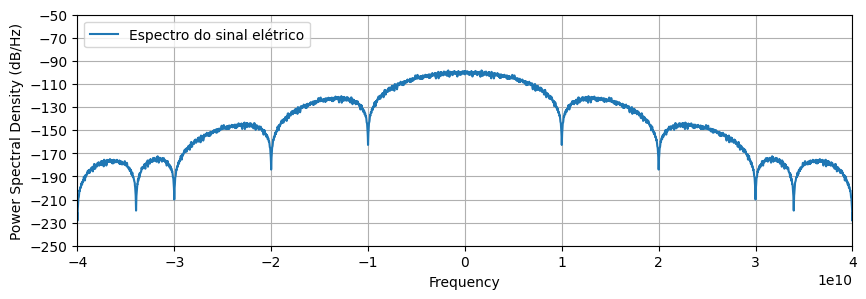

In [ ]:
# generates sequence of pseudo-random bits
bits   = np.random.randint(2, size=10000)    
n      = np.arange(0, bits.size)

# maps bits to electrical pulses
symbTx = 2*bits-1
symbTx = symbTx/np.sqrt(signalPower(symbTx))

# upsampling
symbolsUp = upsample(symbTx, SpS)

# # raised cosine pulse
# Ncoeffs = 640
# rolloff = 0.1

# pulse = pulseShape('rc', SpS, Ncoeffs, rolloff, Ts)
# pulse = pulse/max(abs(pulse))

# typical NRZ pulse
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# pulse formatting
sigTx  = firFilter(pulse, symbolsUp)

# psd plot
plt.figure();
plt.xlim(-4*Rs,4*Rs);
plt.ylim(-250,-50);
plt.psd(sigTx,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal elétrico')
plt.legend(loc='upper left');

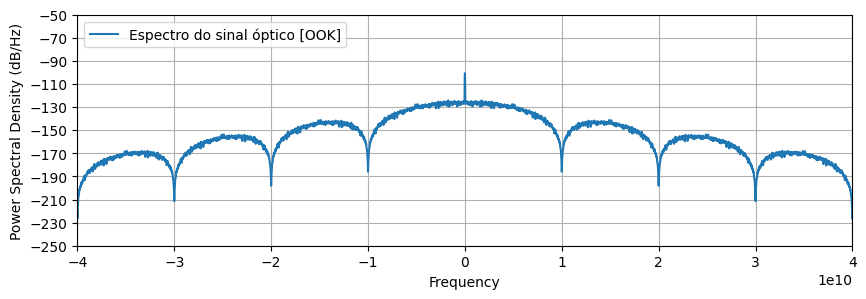

In [37]:
# optical modulation
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi/2

P0 = 100e-3 # CW carrier power at the input to the MZM
Ai = np.sqrt(P0)
sigTxo = mzm(Ai, (paramMZM.Vpi/2)*sigTx, paramMZM)

# psd plot
plt.figure();
plt.xlim(-4*Rs,4*Rs);
plt.ylim(-250,-50);
plt.psd(np.abs(sigTxo)**2,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal óptico [OOK]')
plt.legend(loc='upper left');

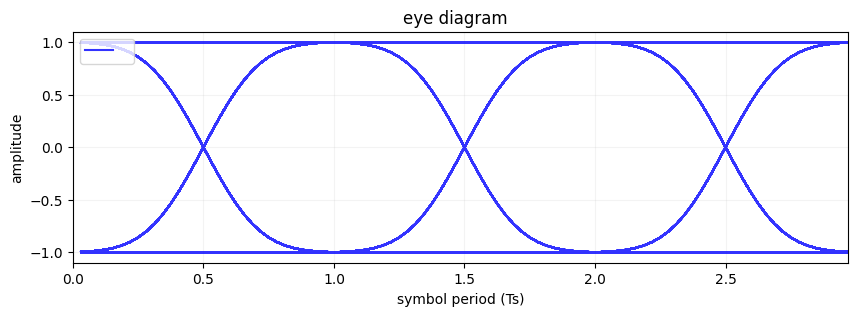

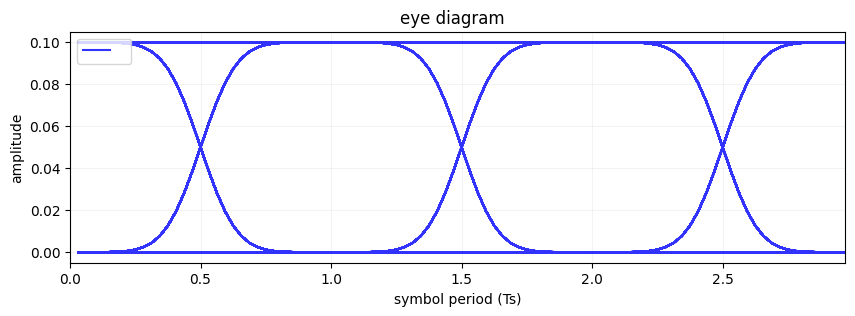

In [38]:
Nsamples = 10000

# eye diagram
eyediagram(sigTx, Nsamples, SpS)
eyediagram(np.abs(sigTxo)**2, Nsamples, SpS)

## Generating M-PAM signals

In [39]:
def genConst(M, plotBits):
    constType='pam'
    
    try:
        plt.figure(figsize=(4,4))
        plt.plot([],[])
        plt.grid()
        plt.ylabel('$A_Q$', fontsize=14)
        plt.xlabel('$A_I$', fontsize=14)
        plt.axis('square')

        # plot modulation bit-to-symbol mapping
        constSymb = grayMapping(M, constType)             # Gray constellation mapping
        bitMap = demodulateGray(constSymb, M, constType)  # bit mapping
        bitMap = bitMap.reshape(-1, int(np.log2(M)))

        # generate random bits
        bits = bitMap.reshape(1, -1)

        # Map bits to constellation symbols
        symbTx = modulateGray(bits, M, constType)

        # normalize symbols energy to 1
        if constType == 'ook':
            plt.xlim(-1.25*max(symbTx.real),1.25*max(symbTx.real))
            plt.ylim(-1.25*max(symbTx.real),1.25*max(symbTx.real));
            plt.vlines(0, -1.25*max(symbTx.real),1.25*max(symbTx.real))
            plt.hlines(0, -1.25*max(symbTx.real),1.25*max(symbTx.real))
        else:
            plt.xlim(1.25*min(symbTx.real),1.25*max(symbTx.real))
            plt.ylim(1.25*min(symbTx.real),1.25*max(symbTx.real));
            plt.vlines(0, 1.25*min(symbTx.real), 1.25*max(symbTx.real))
            plt.hlines(0, 1.25*min(symbTx.real), 1.25*max(symbTx.real))
        
        if M>64:
            plt.plot(symbTx.real, symbTx.imag,'o', markersize=4);
        else:
            plt.plot(symbTx.real, symbTx.imag,'o', markersize=10);                
      
        plt.title('Constelação '+str(M)+'-'+constType.upper());
        
        if plotBits:
            if M>=64:
                fontSize = 6
            else:
                fontSize = 12

            for ind, symb in enumerate(constSymb):
                bitMap[ind,:]
                plt.annotate(str(bitMap[ind,:])[1:-1:2], xy = (symb.real-0.05, symb.imag+0.15), size=fontSize)
        
    except:
        return    
    
interact(genConst, M=[2, 4, 8, 16, 64, 256, 1024], plotBits=[True, False]);

interactive(children=(Dropdown(description='M', options=(2, 4, 8, 16, 64, 256, 1024), value=2), Dropdown(descr…

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
bits 0,1,1,1,0,1,1,1,1,1,0,0,0,1,1,0,1,1,1,0,1
bits 1,1,1,0,0,0,1,0,1,1,0,0,0,1,1,1,1,0,0,1,0


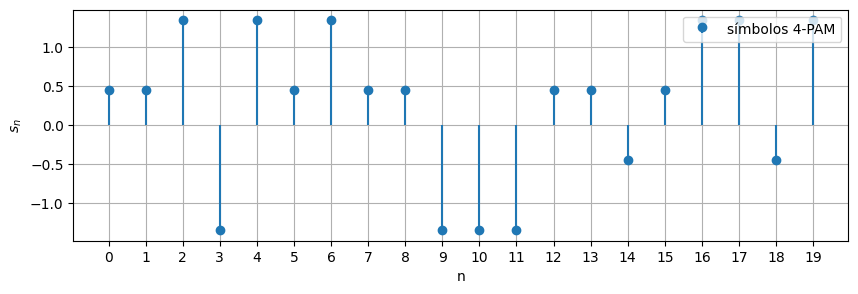

In [40]:
# simulation parameters
M = 4               # modulation order
constType = 'pam'   # modulation type
SpS = 16            # Samples by symbol
Rs  = 10e9          # Symbol Rate
Ts  = 1/Rs          # Symbol period in seconds
Fa  = 1/(Ts/SpS)    # Signal sampling frequency (samples/second)
Ta  = 1/Fa          # Sampling period

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size = int(20*np.log2(M)))

# generate ook modulated symbol sequence
symbTx = modulateGray(bitsTx, M, constType)    
symbTx = pnorm(symbTx) # power normalization

plt.stem(symbTx, basefmt=" ", label ='símbolos 4-PAM')
plt.xlabel('n')
plt.ylabel('$s_n$')
plt.grid()
plt.legend(loc='upper right')
plt.xticks(np.arange(0, symbTx.size));

df = pd.DataFrame()
for b in range(int(np.log2(M))):
    df['bits '+str(b)] = bitsTx[b::int(np.log2(M))]

display(df.T)

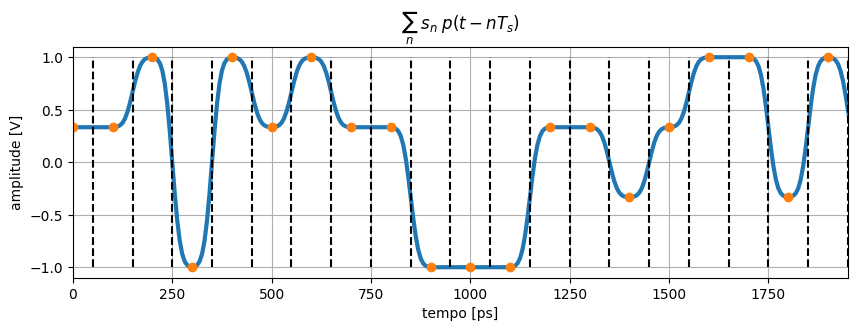

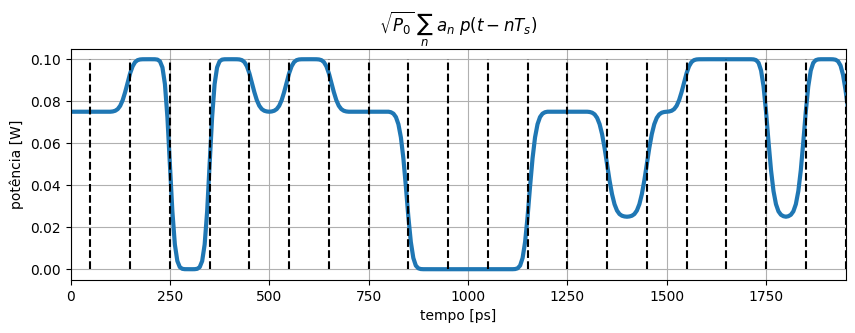

In [ ]:
# upsampling
symbolsUp = upsample(symbTx, SpS)

# typical NRZ pulse
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# pulse formatting
sigTx  = firFilter(pulse, symbolsUp)
sigTx = sigTx.real
sigTx = sigTx/np.max(np.abs(sigTx)) # adjusts signal amplitudes to vary between -1 and 1

t = np.arange(0, sigTx.size)*(Ta/1e-12)

# central instants of signaling intervals
symbolsUp = upsample(symbTx, SpS)
symbolsUp = symbolsUp/np.max(np.abs(symbolsUp))
symbolsUp[symbolsUp==0] = np.nan

plt.figure(2)
plt.plot(t, sigTx,'-',linewidth=3)
plt.plot(t, symbolsUp.real,'o')
plt.xlabel('time [ps]')
plt.ylabel('amplitude [V]')
plt.title('$\sum_{n}\;s_{n}\;p(t-n T_s)$')
plt.grid()

t = (0.5*Ts + np.arange(0, symbTx.size*Ts, Ts))/1e-12
plt.vlines(t, -1, 1, linestyles='dashed', color = 'k');
plt.xlim(0, max(t));

# optical modulation
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi/2

P0 = 100e-3 # CW carrier power at the input to the MZM
Ai = np.sqrt(P0)
sigTxo = mzm(Ai, (paramMZM.Vpi/2)*sigTx, paramMZM)

# signal plot
t = np.arange(0, sigTxo.size)*(Ta/1e-12)

plt.figure(3)
plt.plot(t, np.abs(sigTxo)**2,'-', linewidth=3)
plt.xlabel('time [ps]')
plt.ylabel('potência [W]')
plt.title('$\sqrt{P_0}\;\sum_{n}\;a_{n}\;p(t-n T_s)$')
plt.grid()

t = (0.5 + np.arange(0, symbTx.size))*(Ts/1e-12)
plt.xlim(0, max(t));
plt.vlines(t, 0, P0, linestyles='dashed', color = 'k');
plt.xlim(0, max(t));

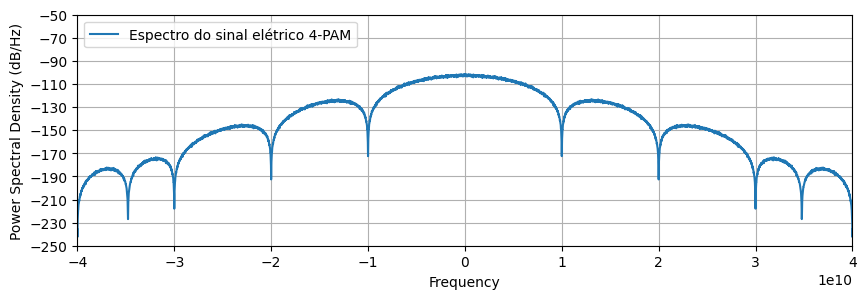

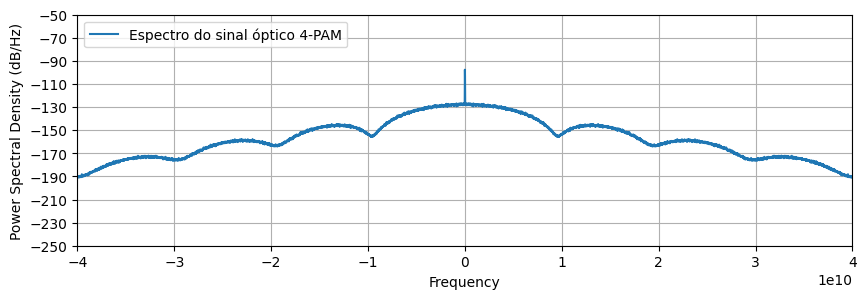

In [42]:
# simulation parameters
M = 4               # modulation order
constType = 'pam'   # modulation type
SpS = 16            # Samples by symbol
Rs  = 10e9          # Symbol Rate
Ts  = 1/Rs          # Symbol period in seconds
Fa  = 1/(Ts/SpS)    # Signal sampling frequency (samples/second)
Ta  = 1/Fa          # Sampling period

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size = int(10e4*np.log2(M)))

# generate ook modulated symbol sequence
symbTx = modulateGray(bitsTx, M, constType)    
symbTx = pnorm(symbTx) # power normalization

# upsampling
symbolsUp = upsample(symbTx, SpS)

# typical NRZ pulse
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# pulse formatting
sigTx  = firFilter(pulse, symbolsUp)
sigTx = sigTx.real
sigTx = sigTx/np.max(np.abs(sigTx)) # adjusts signal amplitudes to vary between -1 and 1

# optical modulation
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi/2

P0 = 100e-3 # CW carrier power at the input to the MZM
Ai = np.sqrt(P0)
sigTxo = mzm(Ai, (paramMZM.Vpi/2)*sigTx, paramMZM)

Nsamples = 20000

# psd plot
plt.figure();
plt.xlim(-4*Rs,4*Rs);
plt.ylim(-250,-50);
plt.psd(sigTx,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal elétrico 4-PAM')
plt.legend(loc='upper left');


# psd plot
plt.figure();
plt.xlim(-4*Rs,4*Rs);
plt.ylim(-250,-50);
plt.psd(np.abs(sigTxo)**2,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal óptico 4-PAM')
plt.legend(loc='upper left');

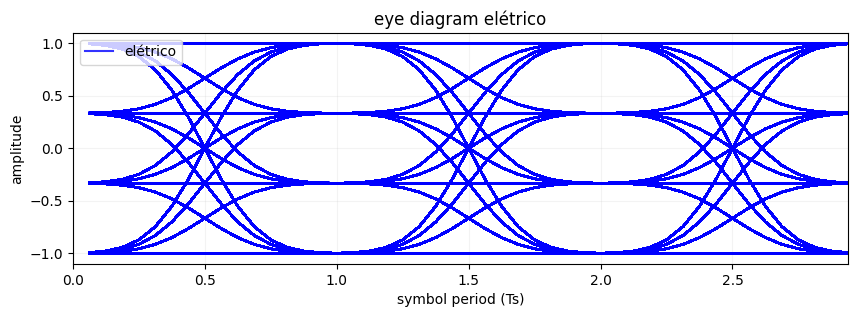

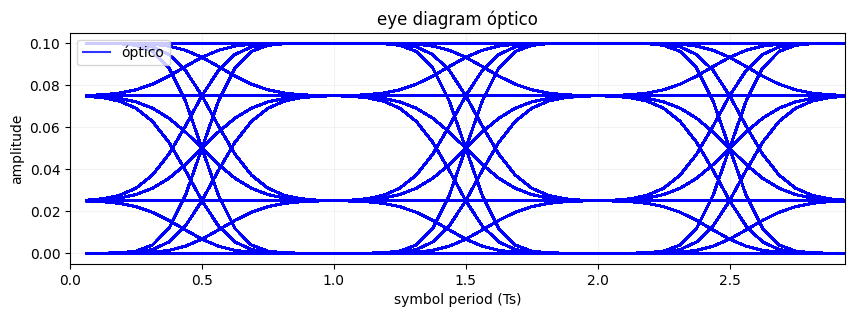

In [43]:
# eye diagram
eyediagram(sigTx, sigTxo.size-SpS, SpS, plotlabel='elétrico')

# eye diagram
eyediagram(np.abs(sigTxo)**2, sigTxo.size-SpS, SpS, plotlabel='óptico')

## Generating phase and quadrature modulated signals (PSK, QAM)

In [44]:
def genConst(M, constType, plotBits):
    try:
        plt.figure(figsize=(4,4))
        plt.plot([],[])
        plt.grid()
        plt.ylabel('$A_Q$', fontsize=14)
        plt.xlabel('$A_I$', fontsize=14)
        plt.axis('square')

        # plot modulation bit-to-symbol mapping
        constSymb = grayMapping(M, constType)             # Gray constellation mapping
        bitMap = demodulateGray(constSymb, M, constType)  # bit mapping
        bitMap = bitMap.reshape(-1, int(np.log2(M)))

        # generate random bits
        bits = bitMap.reshape(1, -1)

        # Map bits to constellation symbols
        symbTx = modulateGray(bits, M, constType)

        # normalize symbols energy to 1
        if constType == 'ook':
            plt.xlim(-1.25*max(symbTx.real),1.25*max(symbTx.real))
            plt.ylim(-1.25*max(symbTx.real),1.25*max(symbTx.real));
            plt.vlines(0, -1.25*max(symbTx.real),1.25*max(symbTx.real))
            plt.hlines(0, -1.25*max(symbTx.real),1.25*max(symbTx.real))
        else:
            plt.xlim(1.25*min(symbTx.real),1.25*max(symbTx.real))
            plt.ylim(1.25*min(symbTx.real),1.25*max(symbTx.real));
            plt.vlines(0, 1.25*min(symbTx.real), 1.25*max(symbTx.real))
            plt.hlines(0, 1.25*min(symbTx.real), 1.25*max(symbTx.real))
        
        if M>64:
            plt.plot(symbTx.real, symbTx.imag,'o', markersize=4);
        else:
            plt.plot(symbTx.real, symbTx.imag,'o', markersize=10);                
      
        plt.title('Constelação '+str(M)+'-'+constType.upper());
        
        if plotBits:
            if M>=64:
                fontSize = 6
            else:
                fontSize = 12

            for ind, symb in enumerate(constSymb):
                bitMap[ind,:]
                plt.annotate(str(bitMap[ind,:])[1:-1:2], xy = (symb.real-0.05, symb.imag+0.15), size=fontSize)
        
    except:
        return    
    
interact(genConst, M=[2, 4, 8, 16, 64, 256, 1024], constType=['psk','qam'], plotBits=[True, False]);

interactive(children=(Dropdown(description='M', options=(2, 4, 8, 16, 64, 256, 1024), value=2), Dropdown(descr…

In [45]:
AI, AQ, t = sp.symbols('A_I, A_Q, t', real=True)

E = AI*cos(omega_c*t) + AQ*sin(omega_c*t)

print('Carrier:')
disp(Math('E(t) = '+sp.latex(E)))

disp(Math('\hat{E}(t) = '+sp.latex(AI+j*AQ)))

Portadora:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<img src="./figuras/IQM.png" width="900">

In [46]:
from optic.models.devices import iqm

help(iqm)

Help on function iqm in module optic.models.devices:

iqm(Ai, u, param=None)
    Optical In-Phase/Quadrature Modulator (IQM).
    
    Parameters
    ----------
    Ai : scalar or np.array
        Amplitude of the optical field at the input of the IQM.
    u : complex-valued np.array
        Modulator's driving signal (complex-valued baseband).
    param : parameter object  (struct)
        Object with physical/simulation parameters of the mzm.
    
        - param.Vpi: MZM's Vpi voltage [V][default: 2 V]
    
        - param.VbI: I-MZM's bias voltage [V][default: -2 V]
    
        - param.VbQ: Q-MZM's bias voltage [V][default: -2 V]
    
        - param.Vphi: PM bias voltage [V][default: 1 V]
    
    Returns
    -------
    Ao : complex-valued np.array
        Modulated optical field at the output of the IQM.
    
    References
    ----------
    [1] M. Seimetz, High-Order Modulation for Optical Fiber Transmission. em Springer Series in Optical Sciences. Springer Berlin Heidelberg,

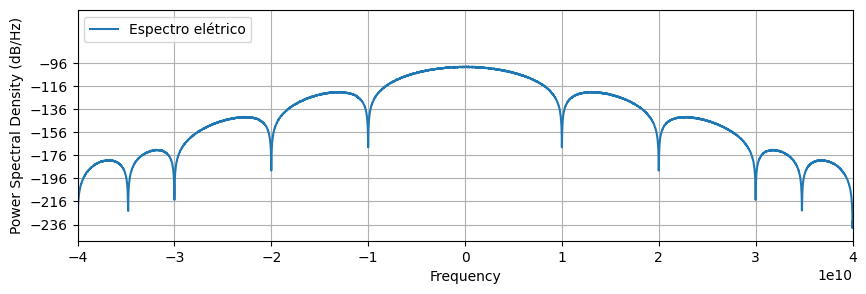

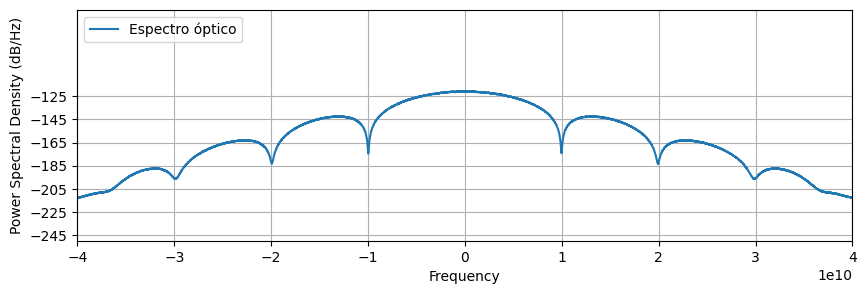

In [47]:
# simulation parameters
M = 16               # modulation order
constType = 'qam'   # modulation type
SpS = 16            # Samples by symbol
Rs  = 10e9          # Symbol Rate
Ts  = 1/Rs          # Symbol period in seconds
Fa  = 1/(Ts/SpS)    # Signal sampling frequency (samples/second)
Ta  = 1/Fa          # Sampling period

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size = int(80e4*np.log2(M)))

# generate ook modulated symbol sequence
symbTx = modulateGray(bitsTx, M, constType)
symbTx = symbTx/np.max(np.abs(symbTx.real)) # adjusts signal amplitudes to vary between -1 and 1

# upsampling
symbolsUp = upsample(symbTx, SpS)

# typical NRZ pulse
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# pulse formatting
sigTx = firFilter(pulse, symbolsUp)

sigTx = sigTx/np.max(np.abs(sigTx.real)) # adjusts signal amplitudes to vary between -1 and 1

# psd plot
plt.figure();
plt.psd(sigTx,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro elétrico')
plt.legend(loc='upper left');
plt.xlim(-4*Rs,4*Rs);
plt.ylim(-250,-50);

# optical modulation
paramIQM = parameters()
paramIQM.Vpi = 2
paramIQM.Vb = -paramIQM.Vpi

P0 = 100e-3 # CW carrier power at the input to the MZM
Ai = np.sqrt(P0)

sigTxo = iqm(Ai, 0.25*paramIQM.Vpi*sigTx, paramIQM)

# psd plot
plt.figure();
plt.psd(sigTxo, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro óptico')
plt.legend(loc='upper left');
plt.xlim(-4*Rs,4*Rs);
plt.ylim(-250,-50);

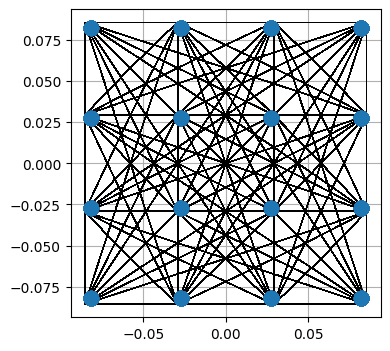

In [ ]:
plt.figure(figsize=(4,4))
plt.plot(sigTxo.real,sigTxo.imag,'k--', linewidth=0.5)
plt.plot(np.sqrt(signalPower(sigTxo))*symbTx.real, np.sqrt(signalPower(sigTxo))*symbTx.imag,'o', markersize=10);
plt.grid()
plt.axis('equal');

# eye diagram
# eyediagram(sigTxo, sigTxo.size-SpS, SpS, ptype='fast')
# eyediagram(np.abs(sigTxo)**2, sigTxo.size-SpS, SpS, ptype='fast')

## Optical pulse shaping: return-to-zero (RZ) pulses

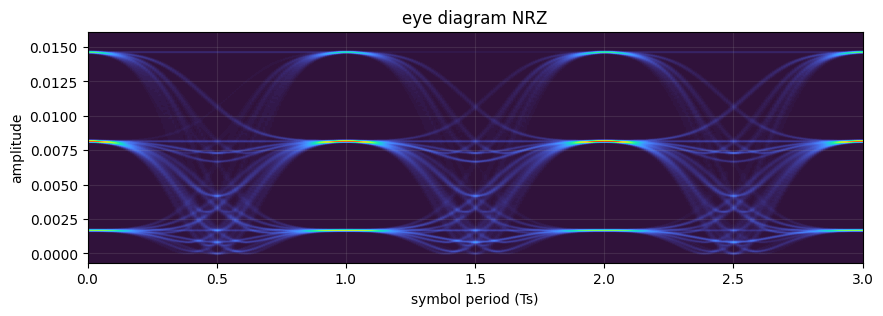

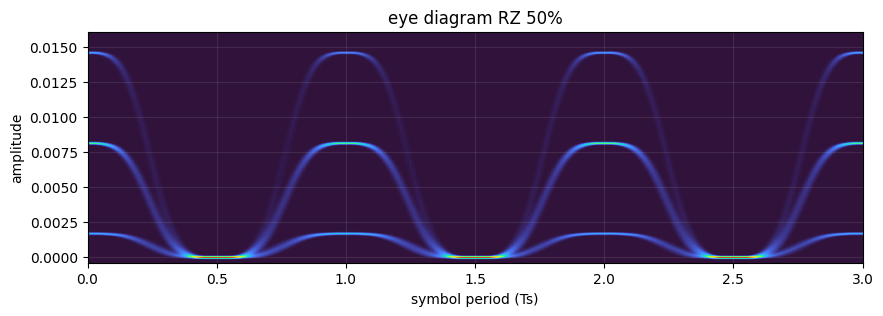

In [49]:
# RZ pulses 50%: Vb = Vπ/2, Vs = Vπ/2, fs = Rs, ϕs = π
# RZ pulses 33%: Vb = 0, Vs = Vπ, fs = Rs/2, ϕs = π/2
# RZ pulses 67%: Vb = Vπ, Vs = Vπ, fs = Rs/2, ϕs = 0

SpS = 16         # Samples by symbol
Rs  = 10e9       # Symbol Rate
Ts  = 1/Rs       # Symbol period in seconds
Fa  = SpS*Rs     # Signal sampling frequency (samples/second)
Ta  = 1/Fa       # Sampling period

t = np.arange(0, sigTxo.shape[0])*Ta

RZ = 50 # RZ pulse type (33%, 50%, 67%)

# MZM parameters
paramMZM = parameters()
paramMZM.Vpi = 2

Ai = 1

# formatter parameters for each RZ pulse type
if RZ == 33:
    
    paramMZM.Vb = 0    
    # sinusoidal signal parameters
    fs = Rs/2
    Vs = paramMZM.Vpi
    ϕs = np.pi/2 
    
elif RZ == 50:
    
    paramMZM.Vb = paramMZM.Vpi/2    
    # sinusoidal signal parameters
    fs = Rs
    Vs = paramMZM.Vpi/2
    ϕs = np.pi
    
elif RZ == 67:
    
    Vb = paramMZM.Vpi    
    # sinusoidal signal parameters
    fs = Rs/2
    Vs = paramMZM.Vpi
    ϕs = 0  

    
# generates sinusoidal signal
senoideRF = Vs*np.cos(2*np.pi*fs*t + ϕs)

# MZM used as a pulse carver
# sigTxo = mzm(Ai, sinusoidRF, paramMZM)
sigTxo_  = mzm(sigTxo, senoideRF, paramMZM)

# eye diagrams
eyediagram(np.abs(sigTxo)**2,sigTxo.size-SpS, SpS, plotlabel='NRZ', ptype='fancy')
# eyediagram(np.abs(mzm(Ai, sinusoidRF, paramMZM))**2, sigTxo.size-SpS, SpS, plotlabel='pulsos RZ '+str(RZ)+'%', ptype='fast')
eyediagram(np.abs(sigTxo_)**2, sigTxo.size-SpS, SpS, plotlabel='RZ '+str(RZ)+'%', ptype='fancy')

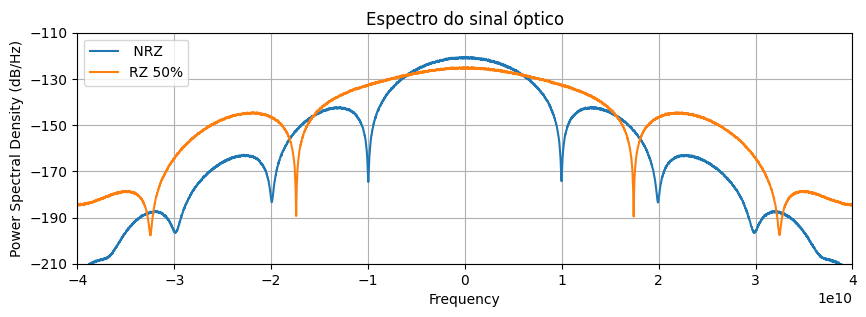

In [50]:
# psd plot
plt.figure();
plt.xlim(-4*Rs,4*Rs);
plt.ylim(-210,-110);
plt.title('Espectro do sinal óptico')
plt.psd(sigTxo,Fs=Fa, NFFT = 16*1024, sides='twosided', label = ' NRZ')
plt.psd(sigTxo_,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'RZ '+str(RZ)+'%')
plt.legend(loc='upper left');

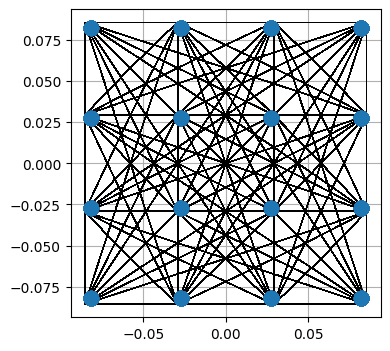

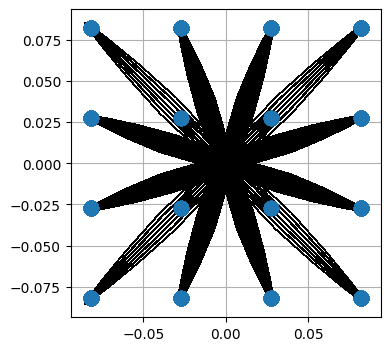

In [ ]:
plt.figure(figsize=(4,4))
plt.plot(sigTxo.real,sigTxo.imag,'k--', linewidth=0.5)
plt.plot(np.sqrt(signalPower(sigTxo))*symbTx.real, np.sqrt(signalPower(sigTxo))*symbTx.imag,'o', markersize=10);
plt.grid()
plt.axis('equal');

plt.figure(figsize=(4,4))
plt.plot(sigTxo_.real,sigTxo_.imag,'k--', linewidth=0.5)
plt.plot(np.sqrt(signalPower(sigTxo))*symbTx.real, np.sqrt(signalPower(sigTxo))*symbTx.imag,'o', markersize=10);
plt.grid()
plt.axis('equal');

## Frequency comb

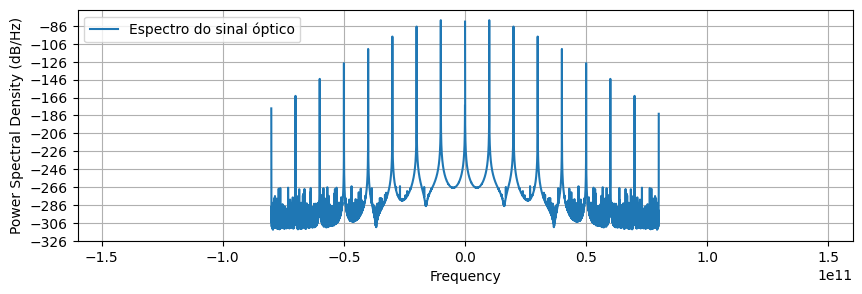

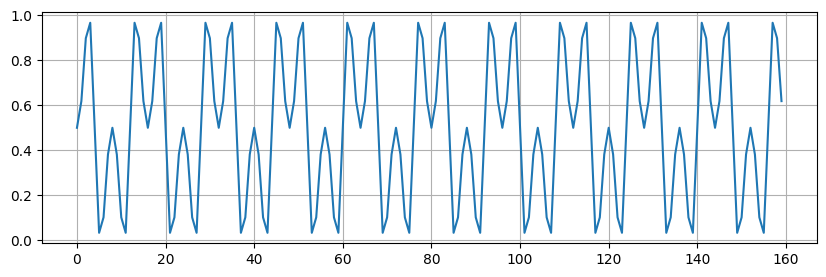

In [54]:
t = np.arange(0, sigTxo.size*8)*Ta

paramMZM = parameters()
paramMZM.Vpi = 2 
paramMZM.Vb = paramMZM.Vpi/2
Ai = 1

senoideRF = 2*Vπ/2*np.cos(2*np.pi*Rs*t + np.pi)

sigTxo_   = mzm(Ai, senoideRF, paramMZM)
# sigTxo_ = mzm(sigTxo_, Vπ, 5*sineRF, Vb)

# psd plot
plt.figure();
plt.psd(sigTxo_,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal óptico')
plt.legend(loc='upper left');
plt.xlim(-16*Rs,16*Rs);
# plt.ylim(-200,-50);

plt.figure();
plt.plot(abs(sigTxo_[0:160])**2);
plt.grid()

## References

[1] G. P. Agrawal, Lightwave Technology: Telecommunication Systems. Wiley-Interscience, 2005.\
[2] J. G. Proakis, M. Salehi, Communication Systems Engineering, 2nd Edition, Pearson, 2002.